# Calib with the Likelihood Ratio

**Goal:** make a MC -> data correction with a likelihood ratio.

There are two methods we could use to do this:
1. With the classifiers, like Lukas has in the `calib_toy_toolkit` and the `CalibMoreOrganizedNotebook` solutions
2. With the Louppe loss

I was training the `Zbb Calib: Motivating exammple` nb in China, but wasn't getting convergence, so was in the process of investigating what was going on so for revising I decided to KISS and debug one step at a time, here just the signal data and MC correction, and save the background subtraction for another step.

Right, and I think I even didn't want the $p_T$ included here right now.


Nicole Hartman

19.12.2023

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Step 0: Data generation reminder

In [23]:
N=int(1e6)

std = 3
mu = 5
delta = .5

s = mu + std* np.random.normal(size=(N,))
s_data = s - delta

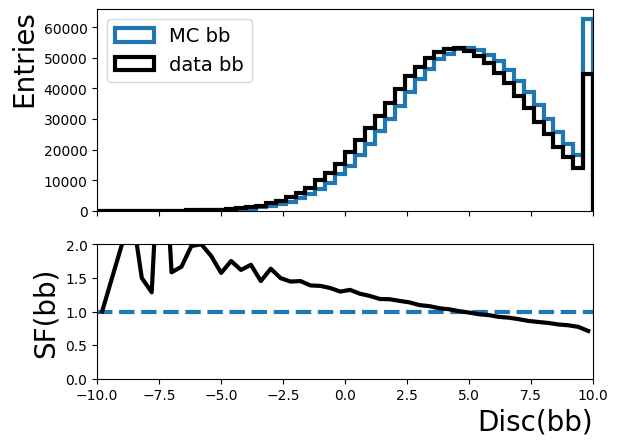

In [87]:
nb = 50
r = (-10,10)
lw = 3

fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))

c_mc = 'C0'
c_dat = 'k'

h_mc,e,_ = ax.hist(np.clip(s,*r),nb,r,histtype='step',color=c_mc,lw=lw,label='MC bb')
h_dat,*_ = ax.hist(np.clip(s_data,*r),nb,r,histtype='step',color=c_dat,lw=lw,label='data bb')
ax_rat.plot(r,[1]*2,c_mc,ls='--',lw=lw)

# Plot the SF
xx = .5 * (e[1:] + e[:-1])
ax_rat.plot(xx[h_mc > 0],h_dat[h_mc > 0] / h_mc[h_mc > 0],color=c_dat,lw=lw)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc(bb)',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF(bb)',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


But also note at the point, the problem is analytical, we don't need to rely on histograms and samplers to setup the problem.

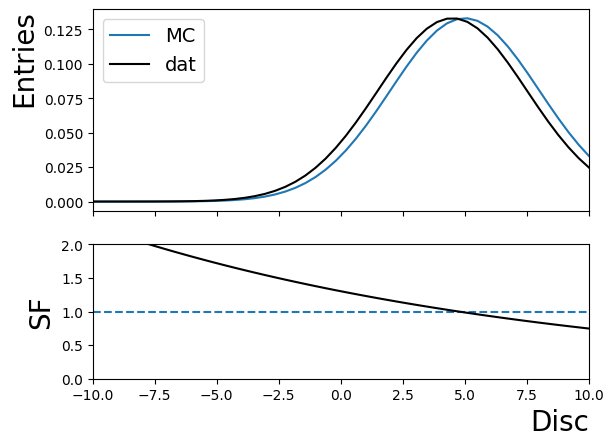

In [90]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))


ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()

### Step 1: Intution building :) Suppose I have a perfect model, what will the loss look like?

**1a) With classifiers**

Suppose we let,
- Class 0: data
- Class 1: MC
and I can train a classifier D(x) to learn the $D(x) = p_{MC}(x)$ (and since I only have two classes, then $p_{dat} = 1 - D(x)$).
Then minimize with the NLL, a.k.a, the BCE loss:

$$\mathcal{L} = \mathbb{E}_{x \sim p_{dat}} \left[ \log (1-D(x))  \right] + \mathbb{E}_{x \sim p_{MC}} \left[ \log D(x)  \right]$$

Then we know the optimal classifier will be:

$$D(x) = \frac{1}{1 + p_{dat}(x) / p_{MC}(x)}$$

which we can then rearrange for the SF:

$$SF(x) = \frac{p_{dat}(x)}{p_{MC}(x)} = \frac{1}{D(x)} - 1$$

In [171]:
def get_true_SF(x):
    # See algebra below when I calculated this for the Louppe loss
    return  np.exp( - (delta * (x - mu) + .5 * delta **2 ) / (std**2) )

In [172]:
def get_opt_class(x):
    '''
    Optimal classifier
    '''
    sf = get_true_SF(x)
    return 1 / (1 + sf)


In [173]:
y_true = np.concatenate([np.zeros(N), np.ones(N) ])
y_pred = np.concatenate([ get_opt_class(s_data) , get_opt_class(s) ])

In [176]:
for i in range(1,7):
    ni = int(10**i)
    li = nn.BCELoss()(torch.FloatTensor(y_pred[:ni]), torch.FloatTensor(y_true[:ni]))
    print(ni,li.numpy())

bce_best = li.numpy()

10 0.6651018
100 0.69216937
1000 0.69299775
10000 0.6904078
100000 0.6901999
1000000 0.6897447


Nice, for an optimal classifier, the loss should get down to about 0.69.

### 1b) With Giles's loss

- Class 1: MC
- Class 0: data
  
$$\mathcal{L} = \mathbb{E}_{x \sim p_{MC}} \left[ \exp \left( \frac{Q(x)}{2}  \right)  \right] + \mathbb{E}_{x \sim p_{dat}} \left[ \exp \left( - \frac{Q(x)} {2} \right)  \right]$$

and exponentiating the output of the NN is the SF here, so taking the log of the ratio of the two SFs should be the best true loss


Ah... so if I substitue the SF into this loss function, I can see that the MC is getting corrected to look like data, and the data is corrected to look like MC (right?)

\begin{align}
\mathcal{L} &= \mathbb{E}_{x \sim p_{MC}} \left[  \sqrt{ \exp Q(x)} \right] + \mathbb{E}_{x \sim p_{dat}} \left[ \sqrt{ \frac{1}{\exp Q(x)}} \right] \\
& = \mathbb{E}_{x \sim p_{MC}} \left[  \sqrt{ SF(x)} \right] + \mathbb{E}_{x \sim p_{dat}} \left[ \sqrt{ \frac{1}{SF(x)}} \right]
\end{align}


In [63]:
def louppe_loss(y_true, y_pred):
    '''
    Loss fct Rafael, HH4b analysis

    Note... this is a _little tricky_ rn, the pred and true are flipped 
    w/r.t. torch.nn.BCELoss
    '''
    
    loss = (y_true * (torch.sqrt(torch.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / torch.sqrt(torch.exp(y_pred))))

    return loss.mean()

**Simplify the \log (p_dat(x) / p_MC(x)) formula**

```p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x-(mu-delta))/std)**2)```

```p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x-mu)/std)**2)```

\begin{align}
\log \left(\frac{p_{dat}(x)}{p_{MC}(s)}\right) &= -\frac{1}{2} ((x-(\mu-\delta))/\sigma)^2 +  \frac{1}{2} ((x-\mu)/\sigma)^2 \\
&= - \frac{1}{2} ((x-\mu)+\delta))/\sigma)^2 + \frac{1}{2} ((x-\mu)/\sigma)^2  \\
&= - (\delta (x-\mu) + 0.5 \delta^2 ) /\sigma^2
\end{align}

In [38]:
def get_true_log_SF(x):
    '''
    Note, the SF _only_ depends on the input features x (right)? 
    So whether it's a data or an MC sample, I can calculate the corresponding SF :D
    '''

    # Calculate the true SF over the elements of a mini-batch
    '''
    p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x-mu)/std)**2)
    p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((x-(mu-delta))/std)**2)

    which we can simplify a bit...
    p_MC =  np.exp(-0.5 * ((x-mu)/std)**2)
    p_dat =  np.exp(-0.5 * ((x-(mu-delta))/std)**2)
    np.log( p_dat / p_MC),
    '''
    
    return  - (delta * (x - mu) + .5 * delta **2 ) / (std**2)


Also note, this factor of 2 (in eqn) or sqrt (in code) doesn't change the minimum of the loss _at all_, 
so I'm guessing it's there to balance the loss to be a trade-off b/w two terms, kind of like the3 JS entropy?
but actually, I have _no idea_

Maybe the details are in the OG paper: 1911.00405
G. V. Moustakides and K. Basioti, 
Training Neural Networks for Likelihood / Density Ratio Estimation 

In [41]:
y_true = np.concatenate([np.zeros(N), np.ones(N) ])
y_pred = np.concatenate([get_true_log_SF(x) for x in [s_data,s]])

In [42]:
y_true

array([0., 0., 0., ..., 1., 1., 1.])

In [43]:
y_pred

array([ 0.08031136,  0.14016001,  0.14724625, ...,  0.30964952,
       -0.24383125, -0.17528918])

In [52]:
for i in range(1,7):
    ni = int(10**i)
    li = louppe_loss(torch.FloatTensor(y_true[:ni]), torch.FloatTensor(y_pred[:ni]))
    print(ni,li.numpy())

10 0.9719694
100 0.9990445
1000 0.999862
10000 0.9972563
100000 0.9970493
1000000 0.9965921


Take away: For 2 sig figs, a batch size of 100 is fine, for 3 sig figs, want a bigger batch size of 10k.

**Step 2:** Train the reweighting functions, and see how the loss c.f. the true "best loss"

In [53]:
def make_batch(N=256, ML_preprocess=False):
    '''
    Batches that don't depend on the pt
    
    Inputs:
    - N: batch size

    Outputs:
    - x: tensor (N,1) (p_bb)
    - y: labels (N,)
        * 1: MC 
        * 0: data
    '''

    # "Blobs" discriminant
    s = mu + std* np.random.normal(size=(N,))
    s_data = s - 0.5

    if ML_preprocess:
        # Normalize the inputs -- here super easy ;)
        raise NotImplementedError

    x = np.concatenate([s,s_data],axis=0)
    y = np.concatenate([np.ones(N),np.zeros(N)],axis=0)
    
    # Shuffle + convert to float tensor
    idx = np.arange(len(y))
    np.random.shuffle(idx)

    x = torch.FloatTensor(x[idx]).reshape(-1,1)
    y = torch.FloatTensor(y[idx]).reshape(-1,1)
    
    return x, y


In [68]:
1024*8

8192

In [69]:
x,y = make_batch(N=8192)

In [56]:
2**4

16

#### Train the BCE Loss

In [178]:
H=64
m = nn.Sequential(
    nn.Linear(1,H),
    nn.ReLU(),
    nn.Linear(H,H),
    nn.ReLU(),
    nn.Linear(H,1),
    nn.Sigmoid()
)

In [179]:
Niter=1000
lr = 1e-4
Nbatch=8192

# init the optimizer
opt = torch.optim.Adam(m.parameters(),lr)
loss = []

for i in range(Niter):

    x,y = make_batch(Nbatch)
    
    m.zero_grad()

    y_pred = m(x)
    li = nn.BCELoss()(y_pred, y)

    li.backward()
    opt.step()

    print(i,li.item())
    loss.append(li.item())

0 0.7463710904121399
1 0.7418125867843628
2 0.7398536205291748
3 0.7366852164268494
4 0.7331525683403015
5 0.730900228023529
6 0.72810298204422
7 0.7257297039031982
8 0.723261296749115
9 0.7206904292106628
10 0.7187715768814087
11 0.7164211869239807
12 0.7140915393829346
13 0.7121614217758179
14 0.7103712558746338
15 0.708474338054657
16 0.7069028615951538
17 0.7052671909332275
18 0.7037269473075867
19 0.7024519443511963
20 0.7013660669326782
21 0.7001210451126099
22 0.6990904211997986
23 0.6981366276741028
24 0.6972725987434387
25 0.6964123249053955
26 0.695791482925415
27 0.695142388343811
28 0.6945405006408691
29 0.6940348148345947
30 0.6936378479003906
31 0.6932870149612427
32 0.6929747462272644
33 0.6926896572113037
34 0.692476749420166
35 0.692305326461792
36 0.6921259164810181
37 0.6920033097267151
38 0.6918668746948242
39 0.691846489906311
40 0.6917912364006042
41 0.6917087435722351
42 0.691718339920044
43 0.6916773319244385
44 0.691719651222229
45 0.6916933059692383
46 0.69160

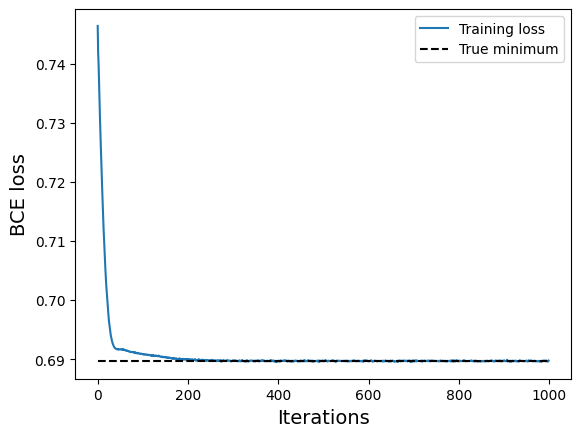

In [180]:
plt.plot(loss,label='Training loss')
plt.plot(range(Niter),[bce_best]*Niter,'k--',label='True minimum')
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('BCE loss',fontsize=14)
plt.legend()
plt.show()

Nice!! It's converging very fast :)

In [189]:
def get_SF(m,x):
    d = m(x).squeeze()
    return (1/d - 1).numpy()

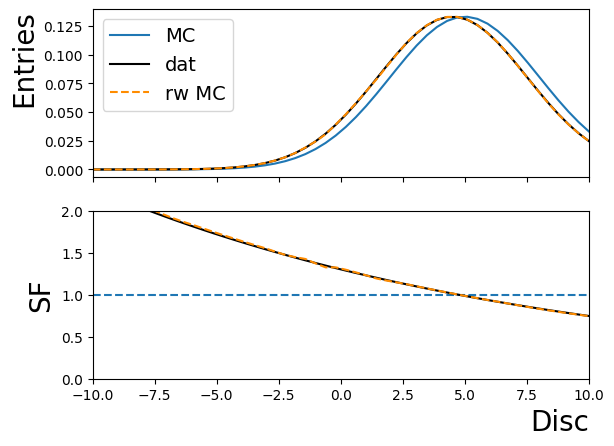

In [194]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

with torch.no_grad():
    sf = get_SF(m,torch.FloatTensor(xx).reshape(-1,1))

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.5,.5))

c_bce = 'darkorange'
ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')
ax.plot(xx,p_MC * sf,c_bce,ls='--',label='rw MC')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat,label='true SF')

ax_rat.plot(xx,sf,color=c_bce,ls='--',label='NN SF')

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC


# ax_rat.legend()

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


#### Train the Louppe loss

In [ ]:
H=64
Q = nn.Sequential(
    nn.Linear(1,H),
    nn.ReLU(),
    nn.Linear(H,H),
    nn.ReLU(),
    nn.Linear(H,1)
)

In [78]:
with torch.no_grad():
    q = Q(x)
    print(louppe_loss(y,Q(x)))

tensor(1.0150)


In [76]:
1.0150/0.9965921

1.0184708467988055

Wow... the loss _wasn't even that far off_ to start with! Maybe I was using too large of a learning rate before?

The NN for this toy problem is trying to learn a 2% correction.

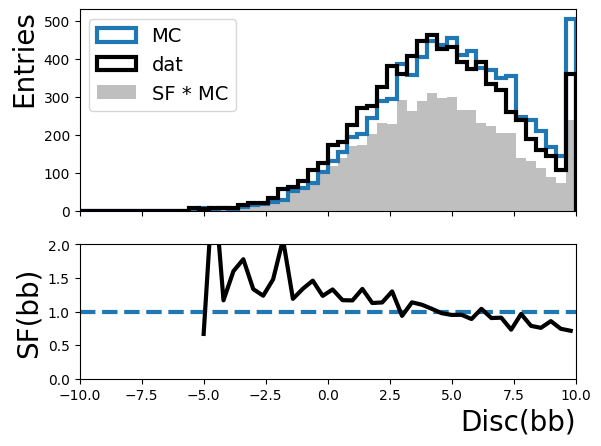

In [104]:
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))

h_mc,e,_ = ax.hist(np.clip(x[y==1],*r),nb,r,histtype='step',color=c_mc,lw=lw,label='MC')
h_dat,*_ = ax.hist(np.clip(x[y==0],*r),nb,r,histtype='step',color=c_dat,lw=lw,label='dat')
h_sf,*_ = ax.hist(np.clip(x[y==1],*r),nb,r,color='grey',alpha=.5,label='SF * MC',weights=np.exp(q[y==1].numpy()))

ax_rat.plot(r,[1]*2,c_mc,ls='--',lw=lw)

# Plot the SF
xx = .5 * (e[1:] + e[:-1])
ax_rat.plot(xx[h_mc > 0],h_dat[h_mc > 0] / h_mc[h_mc > 0],color=c_dat,lw=lw)

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc(bb)',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF(bb)',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


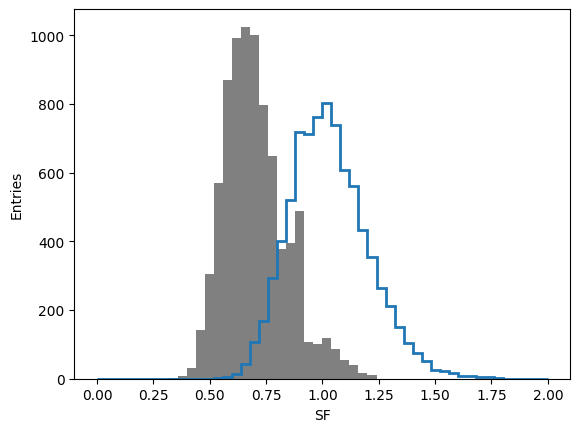

In [111]:
true_weights = np.exp(get_true_log_SF(x[y==0].numpy()))
pred_weights=np.exp(q[y==0].numpy())

plt.hist(pred_weights,nb,(0,2),color='grey',label='pred')
plt.hist(true_weights,nb,(0,2),histtype='step',color=c_mc,lw=2,label='true')
plt.xlabel('SF')
plt.ylabel('Entries')
plt.show()

OK, so we can see why originally the normalization for the SF corrected histogram is smaller, at intialization, this NN has weights very close to 1.

In [ ]:
# def train(m, lr, Niter=)

In [130]:
for p in Q.parameters():
    print(p.squeeze())
    break

tensor([ 0.1256,  0.5333, -0.0670, -0.3488, -0.2864,  0.9166,  0.7198, -0.5025,
        -0.8998,  0.2603,  0.6977,  0.2968, -0.5341, -0.4668, -0.3331,  0.4330,
         0.1964, -0.9433,  0.2144, -0.3487,  0.8913, -0.2188,  0.0072, -0.7249,
        -0.5736, -0.6265,  0.0513, -0.7301, -0.2823, -0.3237,  0.1029, -0.8272,
        -0.1211, -0.8826, -0.3228,  0.0142, -0.7812, -0.2320, -0.6782,  0.5575,
        -0.5034, -0.1794, -0.9223, -0.6755,  0.3077,  0.3205, -0.3065,  0.4828,
        -0.4204, -0.7179, -0.5380, -0.8007,  0.8087,  0.9916, -0.6663, -0.6633,
         0.3316,  0.5701, -0.7564,  0.6184,  0.8531,  0.3896, -0.5834, -0.0730],
       grad_fn=<SqueezeBackward0>)


In [140]:
Niter=1000
lr = 1e-4
Nbatch=8192

m = Q

# init the optimizer
opt = torch.optim.Adam(m.parameters(),lr)
loss = []

for i in range(Niter):

    x,y = make_batch(Nbatch)
    
    m.zero_grad()

    y_pred = m(x)
    li = louppe_loss(y, y_pred)

    li.backward()
    opt.step()

    print(i,li.item())
    loss.append(li.item())

0 0.9977781176567078
1 0.997646152973175
2 0.997596263885498
3 0.9974876046180725
4 0.9974437355995178
5 0.9974510669708252
6 0.9974518418312073
7 0.9973965287208557
8 0.9973018765449524
9 0.9974306225776672
10 0.9972805976867676
11 0.9972344040870667
12 0.9972720146179199
13 0.9971951246261597
14 0.9971340894699097
15 0.9972914457321167
16 0.9971476793289185
17 0.9970685839653015
18 0.997076153755188
19 0.9970405101776123
20 0.9970319867134094
21 0.9969905614852905
22 0.9970022439956665
23 0.9968956708908081
24 0.9969395399093628
25 0.9968871474266052
26 0.9969569444656372
27 0.9968836307525635
28 0.9968543648719788
29 0.9969233274459839
30 0.9967617988586426
31 0.9967970252037048
32 0.9968054890632629
33 0.9967800974845886
34 0.996699869632721
35 0.9968367218971252
36 0.9968030452728271
37 0.9966548681259155
38 0.9966843128204346
39 0.9967209100723267
40 0.9967565536499023
41 0.9966152906417847
42 0.9967373013496399
43 0.9966915845870972
44 0.9966288208961487
45 0.9967297911643982
46

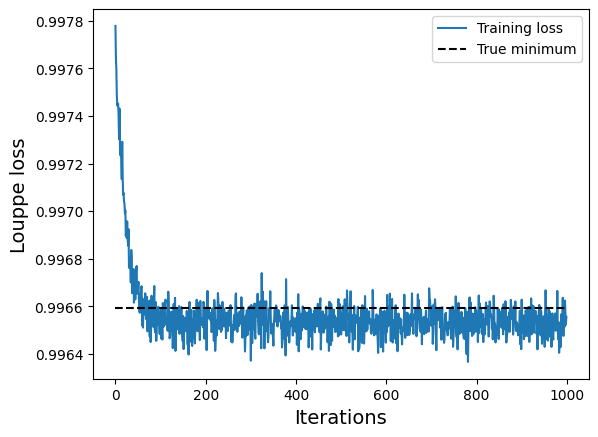

In [141]:
plt.plot(loss,label='Training loss')
plt.plot(range(Niter),[0.9965921]*Niter,'k--',label='True minimum')
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Louppe loss',fontsize=14)
plt.legend()
plt.show()

In [143]:
with torch.no_grad():
    q = Q(x)

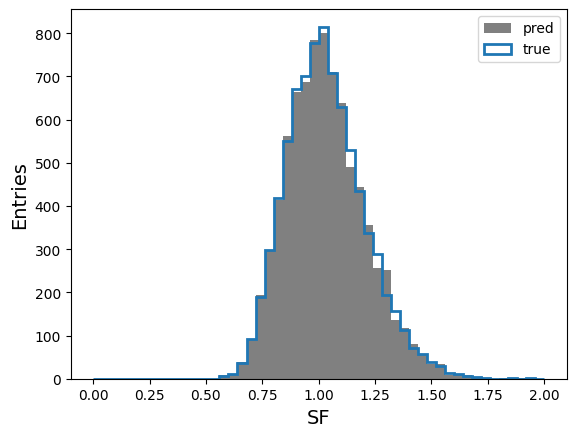

In [146]:
true_weights = np.exp(get_true_log_SF(x[y==0].numpy()))
pred_weights=np.exp(q[y==0].numpy())

plt.hist(pred_weights,nb,(0,2),color='grey',label='pred')
plt.hist(true_weights,nb,(0,2),histtype='step',color=c_mc,lw=2,label='true')
plt.xlabel('SF',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend()
plt.show()

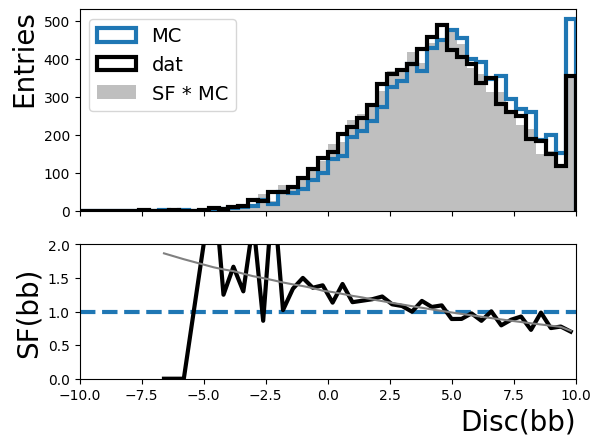

In [149]:
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.6,.4))

h_mc,e,_ = ax.hist(np.clip(x[y==1],*r),nb,r,histtype='step',color=c_mc,lw=lw,label='MC')
h_dat,*_ = ax.hist(np.clip(x[y==0],*r),nb,r,histtype='step',color=c_dat,lw=lw,label='dat')
h_sf,*_ = ax.hist(np.clip(x[y==1],*r),nb,r,color='grey',alpha=.5,label='SF * MC',weights=np.exp(q[y==1].numpy()))

ax_rat.plot(r,[1]*2,c_mc,ls='--',lw=lw)

# Plot the SF
xx = .5 * (e[1:] + e[:-1])
ax_rat.plot(xx[h_mc > 0],h_dat[h_mc > 0] / h_mc[h_mc > 0],color=c_dat,lw=lw)
ax_rat.plot(xx[h_mc > 0],h_sf[h_mc > 0] / h_mc[h_sf > 0],color='grey')

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc(bb)',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF(bb)',fontsize=20,loc='center') #  = dat / MC

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


Nice! It's pretty close to perfect, I think :)

But actually, since my NN takes continuous valued inputs, I don't think I need the use these samples to evaluate the model, I can just use the continuous formulation to compare the true and predicted models

In [165]:
sf

array([2.2577581 , 2.2051125 , 2.1528049 , 2.0998795 , 2.048255  ,
       1.9982158 , 1.9500508 , 1.905147  , 1.8612767 , 1.8202896 ,
       1.7815163 , 1.7435688 , 1.7064296 , 1.6700815 , 1.6345075 ,
       1.5996914 , 1.5656172 , 1.5324491 , 1.5051312 , 1.4710685 ,
       1.4361702 , 1.4058119 , 1.379607  , 1.3507493 , 1.3101448 ,
       1.2899349 , 1.2608742 , 1.2313126 , 1.2084514 , 1.176562  ,
       1.1516035 , 1.1234151 , 1.1011565 , 1.0750104 , 1.050493  ,
       1.0265347 , 1.0031227 , 0.9804032 , 0.9588253 , 0.93693566,
       0.9157275 , 0.8950779 , 0.8748939 , 0.85516506, 0.8358811 ,
       0.8170321 , 0.79860806, 0.7805996 , 0.76299703, 0.7457916 ],
      dtype=float32)

In [168]:
p_MC

array([4.95573172e-07, 9.69452735e-07, 1.86168565e-06, 3.50951355e-06,
       6.49453936e-06, 1.17980612e-05, 2.10394214e-05, 3.68313638e-05,
       6.32940182e-05, 1.06774708e-04, 1.76821463e-04, 2.87450074e-04,
       4.58723225e-04, 7.18620981e-04, 1.10512121e-03, 1.66832554e-03,
       2.47236473e-03, 3.59670765e-03, 5.13639718e-03, 7.20067016e-03,
       9.90941680e-03, 1.33870268e-02, 1.77533792e-02, 2.31120669e-02,
       2.95363891e-02, 3.70541517e-02, 4.56328096e-02, 5.51668773e-02,
       6.54697155e-02, 7.62716892e-02, 8.72262367e-02, 9.79245908e-02,
       1.07918836e-01, 1.16751805e-01, 1.23991185e-01, 1.29264383e-01,
       1.32290240e-01, 1.32903858e-01, 1.31071489e-01, 1.26893605e-01,
       1.20595777e-01, 1.12508497e-01, 1.03038470e-01, 9.26348373e-02,
       8.17542131e-02, 7.08282974e-02, 6.02371367e-02, 5.02901230e-02,
       4.12156292e-02, 3.31590463e-02])

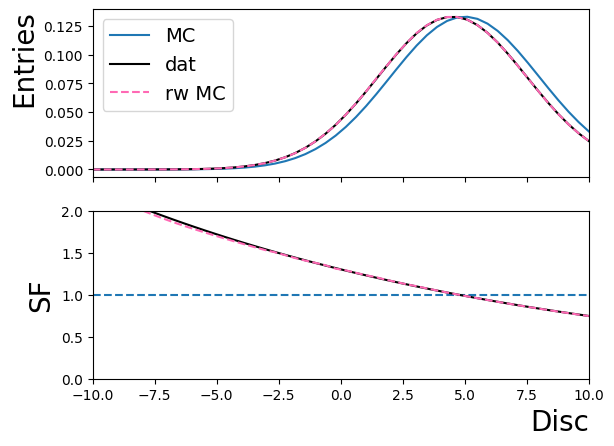

In [170]:
# Get probabilities
xx = np.linspace(*r)

p_MC =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-mu)/std)**2)
p_dat =  1 / ( np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((xx-(mu-delta))/std)**2)

with torch.no_grad():
    q = Q(torch.FloatTensor(xx).reshape(-1,1)).squeeze().numpy()
sf = np.exp(q)

'''
draw plot
'''
fig, (ax,ax_rat) = plt.subplots(2,1, sharex=True, height_ratios=(.5,.5))

c_rw = 'hotpink'
ax.plot(xx,p_MC, c_mc, label='MC')
ax.plot(xx,p_dat,c_dat,label='dat')
ax.plot(xx,p_MC * sf,c_rw,ls='--',label='rw MC')

ax_rat.plot(xx,np.ones_like(xx),color=c_mc,ls='--')
ax_rat.plot(xx,p_dat/p_MC,color=c_dat,label='true SF')

ax_rat.plot(xx,sf,color=c_rw,ls='--',label='NN SF')

ax.legend(fontsize=14)
ax_rat.set_xlabel('Disc',fontsize=20,loc='right')
ax.set_ylabel('Entries',fontsize=20,loc='top')
ax_rat.set_ylabel('SF',fontsize=20,loc='center') #  = dat / MC


# ax_rat.legend()

ax.set_xlim(r)
ax_rat.set_ylim(0,2)
plt.show()


**Q:** Is there a way I could get a meaningful error bar on the prediction?

- OK, I could definitely do smth like a deep ensembles error, but this isn't necessary at this stage of the problem right now b/c visually it's clear we're ~ perfect :)

**Summary thoughts** 
- Amazing, I was working through this notebook trying to understand how to optimize the models on the simplest possible problem... and I succeeded :)
- It turned out the issue I had had in the last example of the `Calib-subtr-bkg` nb was, I was training the Louppe loss, but w/ the wrong architecture (sigmoid for the final activation instead of unbounded) so it makes sense why the model wasn't learning before
- I think it was also super useful for these toy problems to work through what the "best loss" is, so I can optimize accordingly.\


**Next steps:** 
1. Subtract off the background component
2. Scale up the dimensions, a.k.a, adding the $p_T$ as an extra input.

I'm going to start with (1) b/c this was where I got befuddled in the previous notebook.